In [1]:
# -*- coding: utf-8 -*-
# @ Time    : 2024/10/06
# @ Author : zlz.bit.pro@gmail.com
# @ Desc: Example to process the osm_cellids data

# set workspace to the root of the project
import os
workspace_path = '../..'
os.chdir(workspace_path)
print("Current workspace:", os.getcwd())

Current workspace: /users/lingze/neurbench


In [18]:
import numpy as np
from neurbench.index.util import load_key_set, KeyType, save_file
from neurbench.index.bench import KeySetBinEncoder, sample_bulkloading_keyset
from neurbench.drift import find_q

In [3]:
# # load osm_cellids data and downsample it to 200M keys
# keyset_file_path = "/users/lingze/TLI/data/osm_cellids_800M_uint64"
# output_file_path = "/users/lingze/TLI/data/osm_cellids_200M_uint64"
# d = np.fromfile(keyset_file_path, dtype=np.uint64)[1:]

# nd = d[::4]
# with open(output_file_path, "wb") as f:
#     f.write(np.array([nd.size], dtype=np.uint64))
#     nd.tofile(f)


In [3]:
# load osm_cellids_200M_uint64 data
keyset_file_path = "/users/lingze/TLI/data/osm_cellids_200M_uint64"
data = load_key_set(keyset_file_path)


In [4]:
# get data type and check unique
data_type = KeyType.resolve_type_from_filename(keyset_file_path)
print(data_type)
flag = len(np.unique(data)) == len(data)
print("Data is unique:", flag)

KeyType.UINT64


Data is unique: True


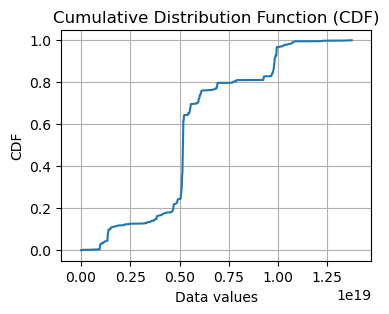

In [5]:
"""plot the data Cumulative Distribution Function (CDF)
"""
max_value = np.max(data)
min_value = np.min(data)
print("Max value:", max_value)
print("Min value:", min_value)
KeySetBinEncoder.plot_cdf(
    data,
    min_value=min_value,
    max_value=max_value,
)

In [6]:
"""abnormal key filter
# before we get the data distribution of key set
# we need to filter out the abnormal keys
"""
keys, removed_key = KeySetBinEncoder.filter_abnormal_values(data, "CONFIDENCE", verbose = True)
print("Remove rate:", len(removed_key) / len(data))

Filtered 3004803 values, [196995198 / 200000001]
Remove rate: 0.015024014924879925


Total number of bins: 243


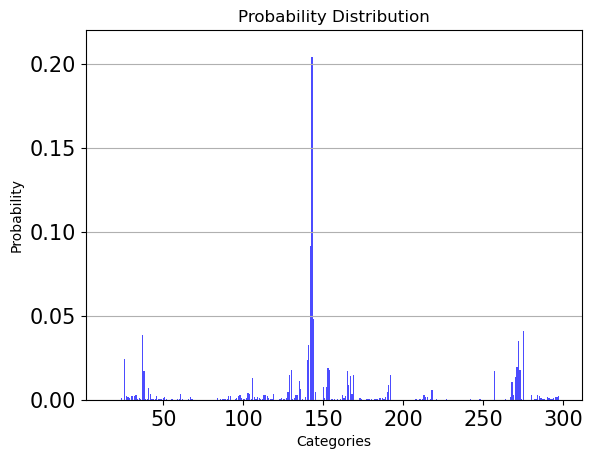

In [12]:
"""Bin the key set, get the distribution of key set
heuristically choose the bin size.
"""
bin_width_offset = 55
bin_idxs, prob, bin_idx_to_keys = KeySetBinEncoder.bin_keyset_to_distribution(
    keys,
    bin_width_offset=bin_width_offset,
    verbose=True
)
KeySetBinEncoder.plot_probability_distribution(prob, bin_idxs.tolist())

In [13]:

min_bin_num = int(np.min(bin_idxs))
max_bin_num = int(np.max(bin_idxs))
prob_dict = {}

for i, idx in enumerate(bin_idxs):
    prob_dict[idx] = prob[i]

x = [ i for i in range(min_bin_num, max_bin_num+1)]
y = [ prob_dict[i] if i in prob_dict else 0.0 for i in range(min_bin_num, max_bin_num+1) ]

0.22


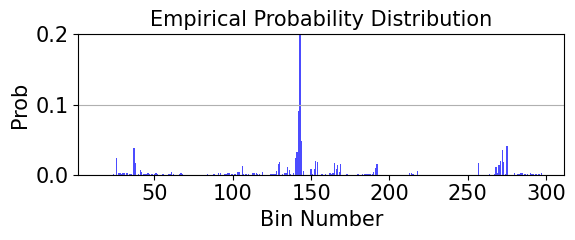

In [14]:
# draw the estimated distribution and store the figure
import matplotlib.pyplot as plt
labels = x
max_value = max(y)
rounded_max_value = np.ceil(max_value * 50) / 50
# rounded 0.05
plt.rcParams['xtick.labelsize']=15
plt.rcParams['ytick.labelsize']=15
fig, ax = plt.subplots(figsize=(6, 2.5))
ax.bar(labels, y, color='blue', alpha=0.7)
ax.set_xlabel('Bin Number', fontsize = 15)
ax.set_ylabel('Prob', fontsize = 15)
ax.set_title('Empirical Probability Distribution', fontsize = 15)
print(rounded_max_value)
ax.set_ylim(0, 0.2)  # Set y-axis limits from 0 to 1
ax.grid(axis='y')
fig.tight_layout()
# filepath = "/users/lingze/neurbench/data/keys/fb_200M_uint64_distribution.pdf"
# fig.savefig(filepath, dpi = 800, bbox_inches = 'tight', pad_inches=0)
# Show the plot
fig.show()

---
### Drift 0.1

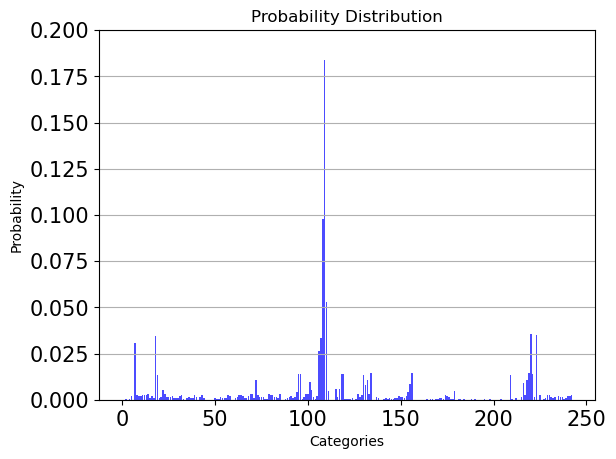

In [21]:
# Drift setting alpha = 0.1, unform drift
init_prob = find_q(prob, 0.1, skewed=False)
KeySetBinEncoder.plot_probability_distribution(init_prob)

In [23]:
bulkloading_n = int(0.52 * len(keys))
bulkloading_keys = sample_bulkloading_keyset(
    bin_idxs,
    init_prob,
    bin_idx_to_keys,
    bulkloading_n,
    verbose=True
)
print(len(bulkloading_keys)) 
print("Bulkloading key set size:", len(bulkloading_keys) / len(keys))

Exceeding the number of keys in bin 16, sample_n: 7193, bound_n: 3
Exceeding the number of keys in bin 17, sample_n: 8409, bound_n: 134
Exceeding the number of keys in bin 18, sample_n: 12873, bound_n: 12504
Exceeding the number of keys in bin 21, sample_n: 7182, bound_n: 2
Exceeding the number of keys in bin 22, sample_n: 37730, bound_n: 23382
Exceeding the number of keys in bin 25, sample_n: 7378, bound_n: 21
Exceeding the number of keys in bin 36, sample_n: 117838, bound_n: 46636
Exceeding the number of keys in bin 39, sample_n: 100467, bound_n: 54748
Exceeding the number of keys in bin 40, sample_n: 168378, bound_n: 104536
Exceeding the number of keys in bin 43, sample_n: 124220, bound_n: 66971
Exceeding the number of keys in bin 44, sample_n: 165527, bound_n: 129021
Exceeding the number of keys in bin 45, sample_n: 152958, bound_n: 102277
Exceeding the number of keys in bin 49, sample_n: 109795, bound_n: 79626
Exceeding the number of keys in bin 50, sample_n: 232423, bound_n: 2163

Total number of bins: 243


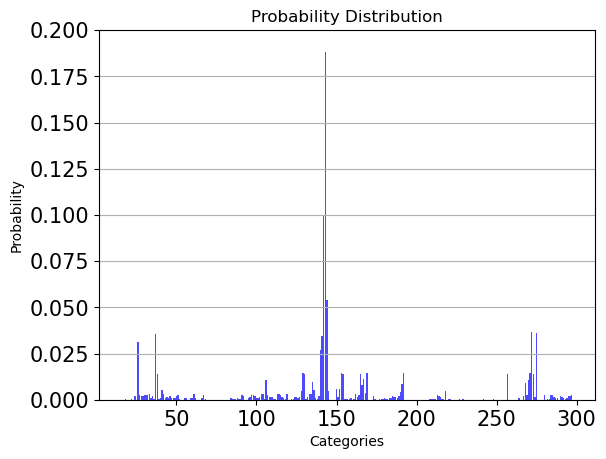

In [26]:
"""Bin the key set, get the distribution of key set
heuristically choose the bin size.
"""
bin_width_offset = 55
bin_idxs, ini_prob, _ = KeySetBinEncoder.bin_keyset_to_distribution(
    np.array(bulkloading_keys),
    bin_width_offset=bin_width_offset,
    verbose=True
)
KeySetBinEncoder.plot_probability_distribution(ini_prob, bin_idxs.tolist())

In [27]:
inserted_keys = np.setdiff1d(data, bulkloading_keys)
print("Insert number of records:", len(inserted_keys))
print("Insert ratio:", len(inserted_keys) / len(data))

Insert number of records: 100117872
Insert ratio: 0.5005893574970532


In [28]:

# draw the picture of the bulkloading key 
prob_dict = {}
for i, idx in enumerate(bin_idxs):
    prob_dict[idx] = ini_prob[i]
y = [ prob_dict[i] if i in prob_dict else 0.0 for i in range(min_bin_num, max_bin_num+1) ]

0.2


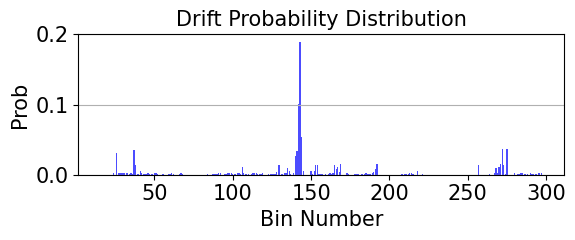

In [30]:
# draw the estimated distribution and store the figure
import matplotlib.pyplot as plt
labels = x
max_value = max(y)
rounded_max_value = np.ceil(max_value * 10) / 10
# rounded 0.05
plt.rcParams['xtick.labelsize']=15
plt.rcParams['ytick.labelsize']=15
fig, ax = plt.subplots(figsize=(6, 2.5))
ax.bar(labels, y, color='blue', alpha=0.7)
ax.set_xlabel('Bin Number', fontsize = 15)
ax.set_ylabel('Prob', fontsize = 15)
ax.set_title('Drift Probability Distribution', fontsize = 15)
print(rounded_max_value)
ax.set_ylim(0, rounded_max_value)  # Set y-axis limits from 0 to 1
ax.grid(axis='y')
fig.tight_layout()
filepath = "/users/lingze/neurbench/data/keys/osm_cellids_200M_uint64_distribution_drift_01.pdf"
fig.savefig(filepath, dpi = 800, bbox_inches = 'tight', pad_inches=0)
# Show the plot
fig.show()

In [31]:
workload_dir_path = "/users/lingze/neurbench/data/workload/osm_cellids_200M_uint64_drift_01"
os.makedirs(workload_dir_path, exist_ok=True)

inserted_keys = np.array(inserted_keys, dtype=data_type.to_numpy_type())
bulkloading_keys = np.array(bulkloading_keys, dtype=data_type.to_numpy_type())

bulkloading_keyset_file_path = os.path.join(workload_dir_path, "init_keys_uint64")
insert_keyset_file_path = os.path.join(workload_dir_path, "insert_keys_uint64")
save_file(bulkloading_keyset_file_path, bulkloading_keys, data_type)
save_file(insert_keyset_file_path, inserted_keys, data_type)

---
### Drift 0.7

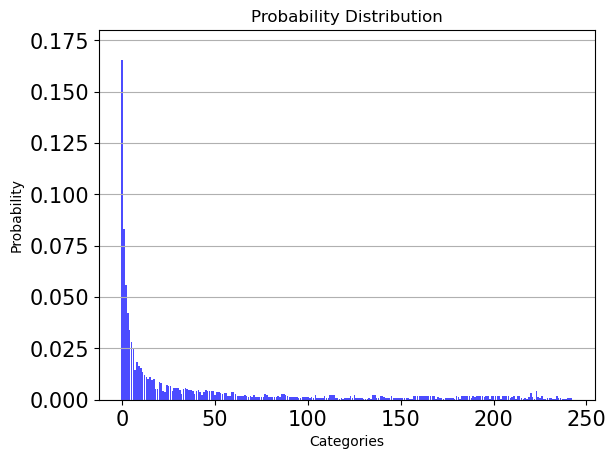

In [33]:
# Drift setting alpha = 0.1, unform drift
init_prob = find_q(prob, 0.7, skewed=False)
KeySetBinEncoder.plot_probability_distribution(init_prob)